<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Matrix Method in Dynamics (Python - Notebook 3 with solutions)
    
In this notebook you will continue your implementation of the matrix method and adjust it in order to be able to solve more complicated 1D structures using the dynamic stiffness matrix method.
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Node class
The `Node` class from last week is pasted here for convenience and without changes.

**The code below does not need any modification**.

In [2]:
class Node:
    ndof = 0
    nn   = 0
    
    def clear():
        Node.ndof = 0
        Node.nn = 0
        
    def __init__ (self, x, y):  
        self.x     = x
        self.y     = y
        self.p     = np.zeros(3, dtype=complex)

        self.dofs  = [Node.ndof, Node.ndof+1, Node.ndof+2]

        Node.ndof += 3
        Node.nn   += 1

    def add_load (self, p):  
        self.p += p

## The Element class

Copy/paste your `Element` class from last week in the code block below. Use it as a basis for the changes you should make in this notebook.

**The code below includes:**
- Code a function with header `def add_distributed_load ( self, q ):` that computes the equivalent load vector for a **constant load** $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have **two** nodes per element!). Also keep local/global transformations in mind and store `self.q = q` for later use;
- Code a function with header `def bending_moments ( self, u_global, num_points=2 ):` that receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in Maple to compute an expression for M (here you will need the `self.q` you stored before). You will also need a `np.linspace()` to get your range of points.

In [3]:
class Element:
    ne = 0

    def clear():
        Element.ne = 0
        
    def __init__ (self, nodes):
        self.nodes = nodes

        self.L = np.sqrt((nodes[1].x - nodes[0].x)**2.0 + (nodes[1].y - nodes[0].y)**2.0)

        dx = nodes[1].x - nodes[0].x
        dy = nodes[1].y - nodes[0].y

        self.cos = dx / self.L
        self.sin = dy / self.L

        R = np.zeros ((6,6))

        R[0,0] = R[1,1] = R[3,3] = R[4,4] = self.cos
        R[0,1] = R[3,4] = -self.sin
        R[1,0] = R[4,3] =  self.sin
        R[2,2] = R[5,5] = 1.0
        
        self.R  = R
        self.Rt = np.transpose(R)

        Element.ne += 1

    def set_section (self, props):
        
        if 'EA' in props:
            self.EA = props['EA']
        else:
            self.EA = 1.e20
            
        if 'ksi' in props: # MODIFIED
            self.ksi = props['ksi'] # MODIFIED
        else: # MODIFIED
            self.ksi = 0.01  # MODIFIED
            
        if 'rhoA' in props:  # MODIFIED
            self.rhoA = props['rhoA']  # MODIFIED
        else:  # MODIFIED
            self.rhoA = 1.e20  # MODIFIED
            
        if 'EI' in props:
            self.EI = props['EI']
        else:
            self.EI = 1.e20
            
        if 'omega' in props:  # MODIFIED
            self.omega = props['omega']  # MODIFIED
        else:   # MODIFIED
            self.omega = 1.e20  # MODIFIED
        
        if 'k_1_r' in props:  # MODIFIED
            self.k_1_r = props['k_1_r']  # MODIFIED
        else:   # MODIFIED
            self.k_1_r = 1.e20  # MODIFIED
            
        if 'k_2_r' in props:  # MODIFIED
            self.k_2_r = props['k_2_r']  # MODIFIED
        else:   # MODIFIED
            self.k_2_r = 1.e20  # MODIFIED
            
        if 'c_1_r' in props:  # MODIFIED
            self.c_1_r = props['c_1_r']  # MODIFIED
        else:   # MODIFIED
            self.c_1_r = 1.e20  # MODIFIED
            
        if 'c_2_r' in props:  # MODIFIED
            self.c_2_r = props['c_2_r']  # MODIFIED
        else:   # MODIFIED
            self.c_2_r = 1.e20  # MODIFIED
        
        if 'k_1_b' in props:  # MODIFIED
            self.k_1_b = props['k_1_b']  # MODIFIED
        else:   # MODIFIED
            self.k_1_b = 1.e20  # MODIFIED
            
        if 'k_2_b' in props:  # MODIFIED
            self.k_2_b = props['k_2_b']  # MODIFIED
        else:   # MODIFIED
            self.k_2_b = 1.e20  # MODIFIED
            
        if 'c_1_b' in props:  # MODIFIED
            self.c_1_b = props['c_1_b']  # MODIFIED
        else:   # MODIFIED
            self.c_1_b = 1.e20  # MODIFIED
            
        if 'c_2_b' in props:  # MODIFIED
            self.c_2_b = props['c_2_b']  # MODIFIED
        else:   # MODIFIED
            self.c_2_b = 1.e20  # MODIFIED
            

    def global_dofs  (self):
        return np.hstack ((self.nodes[0].dofs, self.nodes[1].dofs))

    def stiffness ( self ):
        
        k = np.zeros ((6, 6), dtype=complex) # MODIFIED
        
        ksi = self.ksi # MODIFIED
        EA = self.EA * (1 + 2j * ksi) # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        c_r = (EA/rhoA) ** 0.5  # MODIFIED
        beta_r = omega / c_r  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        k_1_r = self.k_1_r # MODIFIED
        k_2_r = self.k_2_r # MODIFIED
        c_1_r = self.c_1_r # MODIFIED
        c_2_r = self.c_2_r # MODIFIED
        k_1_b = self.k_1_b # MODIFIED
        k_2_b = self.k_2_b # MODIFIED
        c_1_b = self.c_1_b # MODIFIED
        c_2_b = self.c_2_b # MODIFIED

        # Extension contribution

        k[0,0] = EA * beta_r * np.cos(beta_r * L) / np.sin(beta_r * L) + k_1_r + 1j * omega * c_1_r   # MODIFIED
        k[3,3] = EA * beta_r * np.cos(beta_r * L) / np.sin(beta_r * L) + k_2_r + 1j * omega * c_2_r  # MODIFIED
        k[3,0] = - EA * beta_r / np.sin(beta_r * L) # MODIFIED
        k[0,3] = - EA * beta_r / np.sin(beta_r * L) # MODIFIED

        # Bending contribution
        
        K_beam = np.array([[-EI * beta_b ** 3 * (np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 3 * (np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (np.cosh(beta_b * L) - np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (-np.cosh(beta_b * L) + np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * beta_b ** 3 * (np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (-np.cosh(beta_b * L) + np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * beta_b ** 3 * (np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * beta_b ** 2 * (np.cosh(beta_b * L) - np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)]])

        k[1,1] = K_beam[0,0] + (k_1_b + 1j*omega*c_1_b)
        k[1,2] = K_beam[0,1]
        k[1,4] = K_beam[0,2]
        k[1,5] = K_beam[0,3]
        k[2,1] = K_beam[1,0]
        k[2,2] = K_beam[1,1]
        k[2,4] = K_beam[1,2]
        k[2,5] = K_beam[1,3]
        k[4,1] = K_beam[2,0]
        k[4,2] = K_beam[2,1]
        k[4,4] = K_beam[2,2] + (k_2_b + 1j*omega*c_2_b)
        k[4,5] = K_beam[2,3]
        k[5,1] = K_beam[3,0]
        k[5,2] = K_beam[3,1]
        k[5,4] = K_beam[3,2]
        k[5,5] = K_beam[3,3]
        
        #k[1,1] = k[4,4] =  12.0 * EI / L / L / L
        #k[1,4] = k[4,1] = -12.0 * EI / L / L / L
        #k[1,2] = k[2,1] = k[1,5] = k[5,1] = -6.0 * EI / L / L
        #k[2,4] = k[4,2] = k[4,5] = k[5,4] = 6.0 * EI / L / L
        #k[2,2] = k[5,5] = 4.0 * EI / L
        #k[2,5] = k[5,2] = 2.0 * EI / L

        return np.matmul ( np.matmul ( self.Rt, k ), self.R )

    def add_distributed_load ( self, q ):

        L = self.L

        self.q = np.array( q )
        # MODIFIED TO INCLUDE DYNAMIC LOAD UNIFORM DISTRIBUTED:
        el = np.array([(np.cos(beta_r*L) - 1.0)*q[0]/(np.sin(beta_r*L)*beta_r), q[1]*((np.cos(beta_b*L) - 1.0)*np.sinh(beta_b*L) + np.cosh(beta_b*L)*np.sin(beta_b*L) - np.sin(beta_b*L))/(beta_b*(np.cosh(beta_b*L)*np.cos(beta_b*L) - 1.0)) , -q[1]*(np.sinh(beta_b*L)*np.sin(beta_b*L) - np.cosh(beta_b*L) + np.cos(beta_b*L))/(beta_b**2.0*(np.cosh(beta_b*L)*np.cos(beta_b*L) - 1.0)) , (np.cos(beta_r*L) - 1.0)*q[0]/(np.sin(beta_r*L)*beta_r) , q[1]*((np.cos(beta_b*L) - 1)*np.sinh(beta_b*L) + np.cosh(beta_b*L)*np.sin(beta_b*L) - np.sin(beta_b*L))/(beta_b*(np.cosh(beta_b*L)*np.cos(beta_b*L) - 1.0)) , q[1]*(np.sinh(beta_b*L)*np.sin(beta_b*L) - np.cosh(beta_b*L) + np.cos(beta_b*L))/(beta_b**2.0*(np.cosh(beta_b*L)*np.cos(beta_b*L) - 1.0)) ])
        
       # #el = [ 0.5*q[0]*l, 0.5*q[1]*l, -1.0/12.0*q[1]*l*l, 0.5*q[0]*l, 0.5*q[1]*l, 1.0/12.0*q[1]*l*l ]
    
        eg = np.matmul ( self.Rt, el)

        self.nodes[0].add_load ( eg[0:3] )
        self.nodes[1].add_load ( eg[3:6] )
        
    def displacements ( self, u_global, num_points=2 ):
        
        ksi = self.ksi # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        q = self.q[1]

        x = np.linspace ( 0.0, L, num_points )
        M  = np.zeros(num_points)

        ul = np.matmul ( self.R, u_global )
        
        ul = np.concatenate((ul[1:3],ul[4:]))
        
        A = np.array([[(np.sin(beta_b * L) * np.sinh(beta_b * L) + np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.cos(beta_b * L) - np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) - np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(-np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(1 + np.sin(beta_b * L) * np.sinh(beta_b * L) - np.cos(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.sin(beta_b * L) + np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.sin(beta_b * L) * np.cosh(beta_b * L) + np.cos(beta_b * L) * np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) + 1) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.sin(beta_b * L) - np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) - np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) * np.cosh(beta_b * L) - np.cos(beta_b * L) * np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.sin(beta_b * L) + np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2]])
        
        C = A @ (ul + np.array([1/(EI*beta_b**4),0,1/(EI*beta_b**4),0]) * q)
        
        w = C[3] * np.cos(beta_b * x) + C[2] * np.sin(beta_b * x) + C[0] * np.cosh(beta_b * x) + C[1] * np.sinh(beta_b * x) - q / EI / beta_b**4
       
        return w
    
    def rotations ( self, u_global, num_points=2 ):
        
        ksi = self.ksi # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        q = self.q[1]

        x = np.linspace ( 0.0, L, num_points )
        M  = np.zeros(num_points)

        ul = np.matmul ( self.R, u_global )
        
        ul = np.concatenate((ul[1:3],ul[4:]))
        
        A = np.array([[(np.sin(beta_b * L) * np.sinh(beta_b * L) + np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.cos(beta_b * L) - np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) - np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(-np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(1 + np.sin(beta_b * L) * np.sinh(beta_b * L) - np.cos(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.sin(beta_b * L) + np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.sin(beta_b * L) * np.cosh(beta_b * L) + np.cos(beta_b * L) * np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) + 1) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.sin(beta_b * L) - np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) - np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) * np.cosh(beta_b * L) - np.cos(beta_b * L) * np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.sin(beta_b * L) + np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2]])
        
        C = A @ (ul + np.array([1/(EI*beta_b**4),0,1/(EI*beta_b**4),0]) * q)
        
        dw_dx = -C[3] * beta_b * np.sin(beta_b * x) + C[2] * beta_b * np.cos(beta_b * x) + C[0] * beta_b * np.sinh(beta_b * x) + C[1] * beta_b * np.cosh(beta_b * x)
       
        return -dw_dx
    
    def bending_moments ( self, u_global, num_points=2 ):
        
        ksi = self.ksi # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        q = self.q[1]

        x = np.linspace ( 0.0, L, num_points )
        M  = np.zeros(num_points)

        ul = np.matmul ( self.R, u_global )
        
        ul = np.concatenate((ul[1:3],ul[4:]))
        
        A = np.array([[(np.sin(beta_b * L) * np.sinh(beta_b * L) + np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.cos(beta_b * L) - np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) - np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(-np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(1 + np.sin(beta_b * L) * np.sinh(beta_b * L) - np.cos(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.sin(beta_b * L) + np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.sin(beta_b * L) * np.cosh(beta_b * L) + np.cos(beta_b * L) * np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) + 1) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.sin(beta_b * L) - np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) - np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) * np.cosh(beta_b * L) - np.cos(beta_b * L) * np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.sin(beta_b * L) + np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2]])
        
        C = A @ (ul + np.array([1/(EI*beta_b**4),0,1/(EI*beta_b**4),0]) * q)
        
        d2w_dx2 = -C[3] * beta_b ** 2 * np.cos(beta_b * x) - C[2] * beta_b ** 2 * np.sin(beta_b * x) + C[0] * beta_b ** 2 * np.cosh(beta_b * x) + C[1] * beta_b ** 2 * np.sinh(beta_b * x)
        
        M = -EI * d2w_dx2

        return M
    
    def shear_forces ( self, u_global, num_points=2 ):
        
        ksi = self.ksi # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        q = self.q[1]

        x = np.linspace ( 0.0, L, num_points )
        M  = np.zeros(num_points)

        ul = np.matmul ( self.R, u_global )
        
        ul = np.concatenate((ul[1:3],ul[4:]))
        
        A = np.array([[(np.sin(beta_b * L) * np.sinh(beta_b * L) + np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.cos(beta_b * L) - np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) - np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(-np.cos(beta_b * L) * np.sinh(beta_b * L) - np.sin(beta_b * L) * np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(1 + np.sin(beta_b * L) * np.sinh(beta_b * L) - np.cos(beta_b * L) * np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(np.sin(beta_b * L) + np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.sin(beta_b * L) * np.cosh(beta_b * L) + np.cos(beta_b * L) * np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) + 1) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.sin(beta_b * L) - np.sinh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.cos(beta_b * L) - np.cosh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2],[(np.cos(beta_b * L) * np.cosh(beta_b * L) - np.sin(beta_b * L) * np.sinh(beta_b * L) - 1) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(np.sin(beta_b * L) * np.cosh(beta_b * L) - np.cos(beta_b * L) * np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2,(-np.cos(beta_b * L) + np.cosh(beta_b * L)) / (2 * np.cos(beta_b * L) * np.cosh(beta_b * L) - 2),(-np.sin(beta_b * L) + np.sinh(beta_b * L)) / beta_b / (np.cos(beta_b * L) * np.cosh(beta_b * L) - 1) / 2]])
        
        C = A @ (ul + np.array([1/(EI*beta_b**4),0,1/(EI*beta_b**4),0]) * q)
        
        d3w_dx3 = C[3] * beta_b ** 3 * np.sin(beta_b * x) - C[2] * beta_b ** 3 * np.cos(beta_b * x) + C[0] * beta_b ** 3 * np.sinh(beta_b * x) + C[1] * beta_b ** 3 * np.cosh(beta_b * x)
        
        return -EI * d3w_dx3

## The Constrainer class

We give you a new `Constrainer` class here which now also stores possibly non-zero values for displacement boundary conditions. We also add funcionality to `fix_dof` to allow for a non-zero value and accommodate the functions we had before by calling the new one. Finally, we also added a new `full_disp` function that returns the full nodal displacement vector with `u_free` (computed by our solver) and `u_cons` (already known by `Constrainer`, i.e. the prescribed displacement values).

***The implementation below is incomplete***:
- Code the `constrain` function again, but this time taking into account non-zero Dirichlet BCs. Note that we now store `free_dofs` for later use.
- Code a new `support_reactions` functions to compute support reactions. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

In [4]:
class Constrainer:
    def __init__ (self):
        self.cons_dofs = []
        self.cons_vals = []

    def fix_dof (self, node, dof, value=0):
        self.cons_dofs.append(node.dofs[dof])
        self.cons_vals.append(value)
 
    def fix_node (self, node):
        for dof in node.dofs:
            self.fix_dof (node, dof)      

    def full_disp (self,u_free):
        u_full = np.zeros(len(self.free_dofs) + len(self.cons_dofs), dtype=complex)
        
        u_full[self.free_dofs] = u_free
        u_full[self.cons_dofs] = self.cons_vals
        
        return u_full
    
    def constrain (self, k, f):
        self.free_dofs = [i for i in range(len(f)) if i not in self.cons_dofs]
        
        Kff = k[np.ix_(self.free_dofs,self.free_dofs)]
        Kfc = k[np.ix_(self.free_dofs,self.cons_dofs)]
        Ff = f[self.free_dofs]

        return Kff, Ff - np.matmul(Kfc,self.cons_vals)
    
    def support_reactions (self,k,u_free,f):       
        Kcf = k[np.ix_(self.cons_dofs,self.free_dofs)]
        Kcc = k[np.ix_(self.cons_dofs,self.cons_dofs)]
        
        return np.matmul(Kcf,u_free) + np.matmul(Kcc,self.cons_vals) - f[self.cons_dofs]

## Sanity check: Beam with distributed load

Having made your implementations, it is now time to verify your code with a simple sanity check. Here we would like to solve the following simply-supported beam:
<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200 ALIGN="center">
</figure>

Use the code blocks below to set up and solve this problem using the classes above.

### Parameters

We define the parameters here for convenience. We also use the `clear` functions to restart the node, element and DOF counters. Make sure this is done whenever you start solving a new problem.

In [5]:
EA = 7e6
EI = 1.5 * 7e06 # MODIFIED
rhoA = 1e03  # MODIFIED
q_r = 0*1e02 + 0j # MODIFIED
q_b = 1*1e06 + 0j # MODIFIED
L  = 1
omega = 100  # MODIFIED
ksi = 0.01 # MODIFIED
beta_r = omega / (EA*(1+2j*ksi)/rhoA) ** 0.5 # MODIFIED
beta_b = (omega**2 * rhoA / (EI*(1+2j*ksi))) ** 0.25 # MODIFIED
k_1_r, k_2_r, c_1_r, c_2_r, k_1_b, k_2_b, c_1_b, c_2_b = 0, 0, 0, 0, 0, 0, 0, 0

Node.clear()
Element.clear()

### Create nodes

In [6]:
node1 = Node(0,0)
node2 = Node(L,0)

In [7]:
node1

### Create element

In [8]:
elem = Element ( [node1, node2] )

section = {}
section['EA'] = EA
section['EI'] = EI
section['ksi'] = ksi  # MODIFIED
section['rhoA'] = rhoA  # MODIFIED
section['omega'] = omega  # MODIFIED
section['k_1_r'] = k_1_r
section['k_2_r'] = k_2_r
section['c_1_r'] = c_1_r
section['c_2_r'] = c_2_r
section['k_1_b'] = k_1_b
section['k_2_b'] = k_2_b
section['c_1_b'] = c_1_b
section['c_2_b'] = c_2_b

elem.set_section (section)

### Set boundary conditions

The new thing here is to also add the distributed load $q$ to your element. For that, use the new function you implemented in `Element`.

In [9]:
con = Constrainer()

# TRY HERE DIFFERENT BOUNDARY CONDITIONS AND CHECK WITH MAPLE FILE FOR CORRECTNESS OF RESULTS:

con.fix_dof (node1,0)
con.fix_dof (node1,1)
#con.fix_dof (node1,2)
#con.fix_dof (node2,0)
con.fix_dof (node2,1)
#con.fix_dof (node2,2)

elem.add_distributed_load([q_r,q_b])

### Assemble the system of equations

In [10]:
global_k = elem.stiffness()
global_f = np.zeros (6, dtype=complex)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

In [11]:
print(node1.p)

[     0.         +0.j         500662.36185933-13.27231778j
 -83475.26910035 +2.84411147j]


### Constrain the problem and solve for nodal displacements

In [12]:
Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )

print(u_free)


[-0.00400524+8.08845318e-05j  0.00400524-8.08845318e-05j]


In [13]:
print(Kc)

[[41904606.7965719 +840003.10798237j 21071578.36324384+419996.99837152j]
 [21071578.36324384+419996.99837152j 41904606.7965719 +840003.10798237j]]


In [14]:
print(Fc)

[-83475.26910035+2.84411147j  83475.26910035-2.84411147j]


In [15]:
print(global_f)

[     0.         +0.j         500662.36185933-13.27231778j
 -83475.26910035 +2.84411147j      0.         +0.j
 500662.36185933-13.27231778j  83475.26910035 -2.84411147j]


### Support reactions

Here you should call the new function you coded in `Constrainer`

In [12]:
print(con.support_reactions(global_k,u_free,global_f))

[      0.         +0.j         -504005.74516028+80.90481188j
       0.         +0.j         -504005.74516028+80.90481188j]


In [16]:
print(elem.global_dofs())

[0 1 2 3 4 5]


### Moment distribution

Use this block to plot the moment distribution along the element and to get its value at midspan. Use the new `bending_moments` function you implemented in `Element` and `matplotlib` to plot your moment line. 

Note that `bending_moments` expects a full element displacement vector with 6 entries, while our solver only computes `u_free`. We therefore use the new `full_disp` function of `Constrainer` to fill in the gaps for us.

In [17]:
u_elem = con.full_disp(u_free)[elem.global_dofs()]
print(f'u_elem = \n{u_elem}\n')

u_elem = 
[ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
 -0.00400524+8.08845318e-05j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.00400524-8.08845318e-05j]



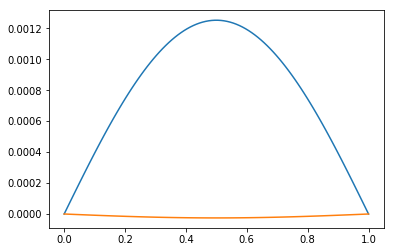

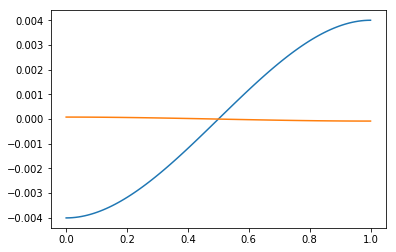

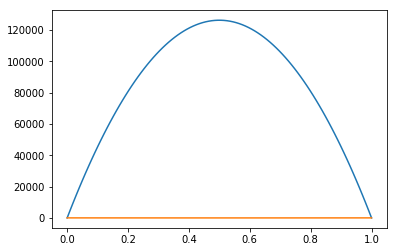

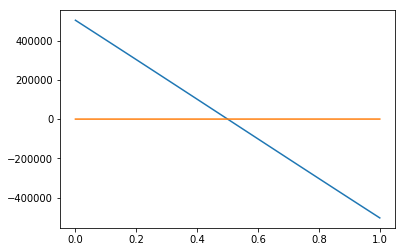

In [14]:
u_elem = con.full_disp(u_free)[elem.global_dofs()]

#print(elem.displacements(u_elem,2))

plt.figure()
plt.plot(np.linspace(0,L,100), elem.displacements(u_elem,100).real)
plt.plot(np.linspace(0,L,100), elem.displacements(u_elem,100).imag)

plt.figure()
plt.plot(np.linspace(0,L,100), elem.rotations(u_elem,100).real)
plt.plot(np.linspace(0,L,100), elem.rotations(u_elem,100).imag)

plt.figure()
plt.plot(np.linspace(0,L,100), elem.bending_moments(u_elem,100).real)
plt.plot(np.linspace(0,L,100), elem.bending_moments(u_elem,100).imag)

plt.figure()
plt.plot(np.linspace(0,L,100), elem.shear_forces(u_elem,100).real)
plt.plot(np.linspace(0,L,100), elem.shear_forces(u_elem,100).imag)

Check MAPLE FILES for solutions. Did your solutions match? If so, that is a sign your implementation is correct.

# Final example: Two-element frame

<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/twoelemframe.png" WIDTH=300 ALIGN="center">
</figure>
    
The final example of this notebook is the two-element frame above. Here you should make use of all the new code you implemented:
    
- Set up the problem and compute a solution for `u_free`. Remember to consider the prescribed horizontal displacement $\bar{u}$ at the right end of the structure.
- Compute and plot bending moment lines for both elements (in their local coordinate systems)
- Compute reactions at both supports
    
You can use the parameters given below. 

### Parameters

In [15]:
EA = 7e6
EI = 1.5 * 7e06 # MODIFIED
rhoA = 1e03  # MODIFIED
q_r = 0*1e02 # MODIFIED
q_b = 1*1e03 # MODIFIED
L  = 10
omega = 100  # MODIFIED
ksi = 0.01 # MODIFIED
beta_r = omega / (EA*(1+2j*ksi)/rhoA) ** 0.5 # MODIFIED
beta_b = (omega**2 * rhoA / (EI*(1+2j*ksi))) ** 0.25 # MODIFIED
k_1_r, k_2_r, c_1_r, c_2_r, k_1_b, k_2_b, c_1_b, c_2_b = 0, 0, 0, 0, 0, 0, 0, 0
phibar = 0.20

Node.clear()
Element.clear()

### Create nodes

In [16]:
nodes = []

nodes.append(Node(0,0))
nodes.append(Node(L,L))
nodes.append(Node(2*L,0))

### Create elements

In [17]:
elems = []

elems.append(Element([nodes[0], nodes[1]]))
elems.append(Element([nodes[1], nodes[2]]))

section = {}
section['EA'] = EA
section['EI'] = EI
section['ksi'] = ksi  # MODIFIED
section['rhoA'] = rhoA  # MODIFIED
section['omega'] = omega  # MODIFIED
section['k_1_r'] = k_1_r
section['k_2_r'] = k_2_r
section['c_1_r'] = c_1_r
section['c_2_r'] = c_2_r
section['k_1_b'] = k_1_b
section['k_2_b'] = k_2_b
section['c_1_b'] = c_1_b
section['c_2_b'] = c_2_b

for elem in elems:
    elem.set_section(section)

### Set boundary conditions

In [18]:
con = Constrainer()

con.fix_dof (nodes[0], 0)
con.fix_dof (nodes[0], 1)
#con.fix_dof (nodes[0], 2)
con.fix_dof (nodes[2], 0)
con.fix_dof (nodes[2], 1)
con.fix_dof (nodes[2], 2, phibar)

elems[0].add_distributed_load([0,q_b])
elems[1].add_distributed_load([0,2*q_b])

### Assemble the system

In [19]:
global_k = np.zeros ((3*len(nodes), 3*len(nodes)), dtype=complex) #MODIFIED
global_f = np.zeros (3*len(nodes), dtype=complex)  #MODIFIED

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

In [20]:
print(global_f)

[  655.97255942-21.88282471j   655.97255942-21.88282471j
    85.48280467+36.87938289j  -655.97255942+21.88282471j
  1967.91767826-65.64847413j    85.48280467+36.87938289j
 -1311.94511884+43.76564942j  1311.94511884-43.76564942j
  -170.96560935-73.75876578j]


### Constrain the problem and solve for nodal displacements

In [21]:
Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

[-0.06610106-0.13661597j -0.1127659 +0.26598199j  0.17125007+0.08734912j
  0.02321956-0.13969737j]


### Support reactions

In [22]:
print(con.support_reactions(global_k,u_free,global_f))

[-1784295.42185292 -301956.30979548j   844715.38367915-1687476.282521j
   759085.58502879 +628852.02575861j  -481501.39400252+2531061.84536431j
  1181832.35893461+1388324.30856383j]


### Moment lines

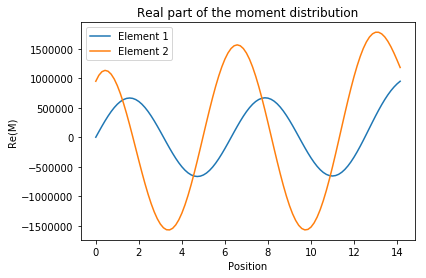

In [23]:
u_full = con.full_disp(u_free)
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = elem.bending_moments(u_elem,100).real
    plt.title('Real part of the moment distribution')
    plt.xlabel('Position')
    plt.ylabel('Re(M)')
    plt.plot(x,y,label='Element '+str(i+1))
    plt.legend()
#    plt.savefig('real moments.png')


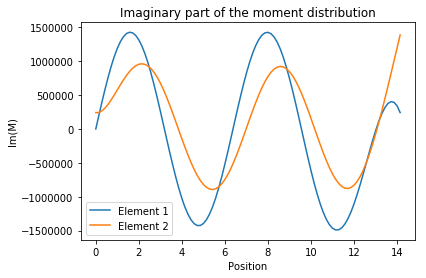

In [24]:
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = elem.bending_moments(u_elem,100).imag
    plt.title('Imaginary part of the moment distribution')
    plt.xlabel('Position')
    plt.ylabel('Im(M)')
    plt.plot(x,y,label='Element '+str(i+1))
    plt.legend()
 #   plt.savefig('imag moments.png')

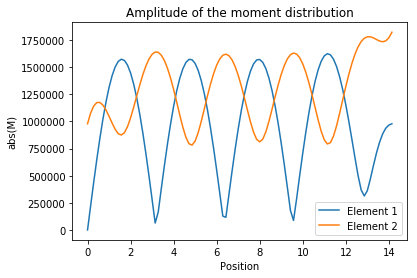

In [25]:
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = abs(elem.bending_moments(u_elem,100))
    plt.title('Amplitude of the moment distribution')
    plt.xlabel('Position')
    plt.ylabel('abs(M)')
    plt.plot(x,y,label='Element '+str(i+1))
    plt.legend()
#    plt.savefig('moment amplitude.png')

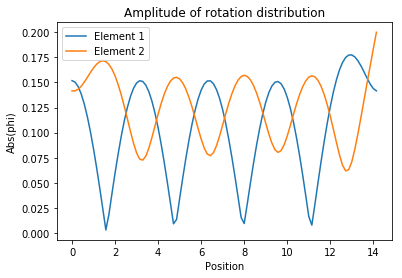

In [26]:
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = abs(elem.rotations(u_elem,100))
    plt.title('Amplitude of rotation distribution')
    plt.xlabel('Position')
    plt.ylabel('Abs(phi)')
    plt.plot(x,y,label='Element '+str(i+1))
    plt.legend()
 #   plt.savefig('Phi.png')


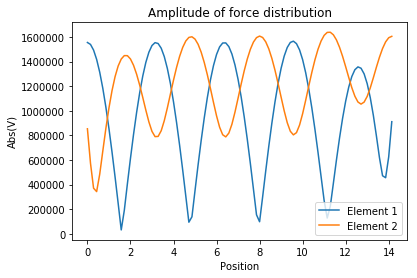

In [27]:
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = abs(elem.shear_forces(u_elem,100))
    plt.title('Amplitude of force distribution')
    plt.xlabel('Position')
    plt.ylabel('Abs(V)')
    plt.plot(x,y,label='Element '+str(i+1))
    plt.legend()
 #   plt.savefig('Phi.png')